# Решение задач средствами SQL запросов #

Импортируем необходимые библиотеки

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine 

### Конфигурация для подключения к базе данных `data-analyst-advanced-sql`
Эта база данных содержит схему `stackoverflow`для работы в проекте

In [2]:
db_config = {
    'user': 'praktikum_student', # имя пользователя
    'pwd': 'Sdf4$2;d-d30pp', # пароль
    'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
    'port': 6432, # порт подключения
    'db': 'data-analyst-advanced-sql' # название базы данных
}  

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

Создание подключения

In [3]:
engine = create_engine(connection_string) 

In [4]:
query = '''
SELECT *
FROM stackoverflow.users
LIMIT 10;
'''

sample_df = pd.read_sql_query(query, con=engine) 

In [5]:
sample_df

,id,creation_date,display_name,last_access_date,location,reputation,views
0,1,2008-07-31 14:22:31,Jeff Atwood,2018-08-29 02:34:23,"El Cerrito, CA",44300,408587
1,2,2008-07-31 14:22:31,Geoff Dalgas,2018-08-23 17:31:56,"Corvallis, OR",3491,23966
2,3,2008-07-31 14:22:31,Jarrod Dixon,2018-08-30 20:56:24,"Raleigh, NC, United States",13418,24396
3,4,2008-07-31 14:22:31,Joel Spolsky,2018-08-14 22:18:15,"New York, NY",28768,73755
4,5,2008-07-31 14:22:31,Jon Galloway,2018-08-29 16:48:36,"San Diego, CA",39172,11700
5,8,2008-07-31 21:33:24,Eggs McLaren,2018-04-09 02:04:56,None,942,6372
6,9,2008-07-31 21:35:27,Kevin Dente,2018-08-30 18:18:03,"Oakland, CA",14337,4949
7,11,2008-08-01 00:59:11,Anonymous User,2008-08-01 00:59:11,None,1890,2123
8,13,2008-08-01 04:18:05,Chris Jester-Young,2018-08-30 02:47:23,"Raleigh, NC, United States",177138,35414
9,17,2008-08-01 12:02:22,Nick Berardi,2018-01-22 01:35:38,"Issaquah, WA",44443,4786


# Задание 1

Выведите общую сумму просмотров постов за каждый месяц 2008 года. Если данных за какой-либо месяц в базе нет, такой месяц можно пропустить. Результат отсортируйте по убыванию общего количества просмотров.

| month_date  | total_views |
| ------------- | ------------- |
| 2008-09-01  | 452928568  |
| 2008-10-01  | 365400138  |
| ...         | ... |

In [6]:
query = '''
SELECT DATE_TRUNC('month', creation_date)::date AS month_date,
       SUM(views_count) AS total_views
FROM stackoverflow.posts
GROUP BY DATE_TRUNC('month', creation_date)
ORDER BY SUM(views_count) DESC;
'''

one = pd.read_sql_query(query, con=engine)
one  

,month_date,total_views
0,2008-09-01,452928568
1,2008-10-01,365400138
2,2008-11-01,221759651
3,2008-12-01,197792841
4,2008-08-01,131367083
5,2008-07-01,669895


Проанализируйте итоговую таблицу. Отличаются ли данные за разные месяцы? С чем могут быть связаны отличия?

Для анализа итоговой таблицы визуализируем динамику просмотров по месяцам, предварительно выделив месяц методом sql.

In [7]:
query = '''
SELECT EXTRACT (MONTH FROM (DATE_TRUNC('month', creation_date)::date)) AS month_date, 
       SUM(views_count) AS total_views
FROM stackoverflow.posts
GROUP BY month_date
ORDER BY SUM(views_count) DESC;
'''
one = pd.read_sql_query(query, con=engine)
one 

,month_date,total_views
0,9.0,452928568
1,10.0,365400138
2,11.0,221759651
3,12.0,197792841
4,8.0,131367083
5,7.0,669895


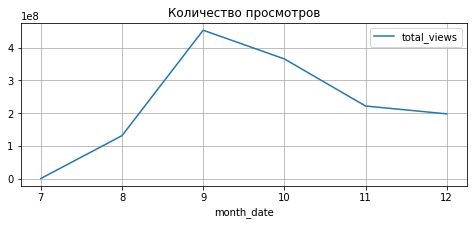

In [8]:
ax = one.pivot_table(index='month_date', values='total_views'
                ).plot( title='Количество просмотров', grid=True,figsize=(8, 3))

 Динамика просмотров такова, что минимальное их количество (почти 670 тыс.) в период создания сайта StackOverflow - июле 2008 года. Пик просмотров достигается в сентябре (более 450 млн.), после чего наступает снижение и в ноябре-декабре их количество составляет около 220-200 млн.
    
Такая динамика характерна для любого нововведения: вначале интерес к новому сайту нарастает, после чего часть пользователей может посчитать для себя этот ресурс бесполезным и перестать им пользоваться. Остается та часть пользователей, которые избрали сайт StackOverflow источником информации на постоянной основе. 
</div> 

<hr style="border: 2px solid green;" />

# Задание 2

Выведите имена самых активных пользователей, которые в первый месяц после регистрации (включая день регистрации) дали больше 100 ответов. Вопросы, которые задавали пользователи, не учитывайте. Для каждого имени пользователя выведите количество уникальных значений `user_id`. Отсортируйте результат по полю с именами в лексикографическом порядке.

| display_name | count |
| ------------ | ----- |
| 1800 INFORMATION | 1 |
| Adam Bellaire | 1 |
| Adam Davis | 1 |
| ... | ... |

In [9]:
query = '''
SELECT 
      us.display_name,
      COUNT(DISTINCT ps.user_id)
FROM stackoverflow.users AS us
JOIN stackoverflow.posts AS ps ON us.id = ps.user_id
JOIN stackoverflow.post_types AS pst ON pst.id = ps.post_type_id
WHERE pst.type = 'Answer'
AND (ps.creation_date::date BETWEEN us.creation_date::date AND (us.creation_date::date + INTERVAL '1 month'))
GROUP BY us.display_name
HAVING COUNT(ps.id)>100
'''
two = pd.read_sql_query(query, con=engine)
two.head()

,display_name,count
0,1800 INFORMATION,1
1,Adam Bellaire,1
2,Adam Davis,1
3,Adam Liss,1
4,Alan,8


Какие аномалии наблюдаются в данных? О чём они говорят?

Для поиска аномальных значений выведем уникальные значения поля "count". В поле "display_name" аномальные значения искать не будем, так как оно сформировано по имени пользователя, которое он может указывать в любом виде.

In [10]:
query = '''
SELECT 
      DISTINCT
      COUNT(DISTINCT ps.user_id)
FROM stackoverflow.users AS us
JOIN stackoverflow.posts AS ps ON us.id = ps.user_id
JOIN stackoverflow.post_types AS pst ON pst.id = ps.post_type_id
WHERE pst.type = 'Answer'
AND (ps.creation_date::date BETWEEN us.creation_date::date AND (us.creation_date::date + INTERVAL '1 month'))
GROUP BY us.display_name
HAVING COUNT(ps.id)>100
'''
two = pd.read_sql_query(query, con=engine)
two

,count
0,1
1,3
2,5
3,7
4,8
5,9
6,10
7,11
8,12
9,15


Запрос выводит для каждого имени кол-во уникальных идентификаторов, значит при регистрации нового пользователя он указывает уже существующее в базе имя и это разрешено - то есть имя пользователя не уникально и можно понять какие имена популярны, то есть это не один и тот же пользователь, а разные с одинаковыми именами


# Задание 3

Выведите количество постов за 2008 год по месяцам. Отберите посты от пользователей, которые зарегистрировались в сентябре 2008 года и сделали хотя бы один пост в декабре того же года. Отсортируйте таблицу по значению месяца по убыванию.

| month | count |
| ------|------ |
| 2008-12-01 | 17641 |
| 2008-11-01 | 18294 |
| ... | ... |

In [11]:
query = '''
WITH n AS
(SELECT                     
       ps.user_id 
FROM stackoverflow.users AS us
JOIN stackoverflow.posts AS ps ON us.id = ps.user_id
WHERE DATE_TRUNC('month', us.creation_date)::date = '2008-09-01'
AND DATE_TRUNC('month', ps.creation_date)::date =  '2008-12-01')

SELECT DATE_TRUNC('month', ps.creation_date)::date AS month,
       COUNT(ps.id)       
       FROM stackoverflow.posts AS ps
       WHERE ps.user_id IN (SELECT *
                            FROM n)
       AND DATE_TRUNC('year', ps.creation_date)::date = '2008-01-01'
       GROUP BY DATE_TRUNC('month', ps.creation_date)::date
       ORDER BY DATE_TRUNC('month', ps.creation_date)::date DESC;                      
'''
three = pd.read_sql_query(query, con=engine)
three

,month,count
0,2008-12-01,17641
1,2008-11-01,18294
2,2008-10-01,27171
3,2008-09-01,24870
4,2008-08-01,32


Изучите данные: есть ли в них аномалии? Предположите, почему могли появиться аномальные значения.

В полученных данных есть аномалия: одним из условий отбора была регистрация пользователей  в сентябре 2008 года. Вместе с тем, группировка по дате размещения такими пользователями постов показала, что 32 поста опубликованы в августе 2008 года, т.е. на месяц раньше их регистрации. Выберем данные об этих пользователях.

In [12]:
query = '''
WITH n AS
(SELECT                   
       ps.user_id      
FROM stackoverflow.users AS us
JOIN stackoverflow.posts AS ps ON us.id = ps.user_id
WHERE DATE_TRUNC('month', us.creation_date)::date = '2008-09-01'
AND DATE_TRUNC('month', ps.creation_date)::date =  '2008-12-01')

SELECT DISTINCT ps.user_id,
      DATE_TRUNC('month', ps.creation_date)::date AS month_creation_date
      FROM stackoverflow.posts AS ps
      WHERE ps.user_id IN (SELECT *
                            FROM n)
      AND DATE_TRUNC('month', ps.creation_date)::date = '2008-08-01'
                           
'''
three = pd.read_sql_query(query, con=engine)
three

,user_id,month_creation_date
0,4381,2008-08-01
1,31505,2008-08-01


Таких пользователей в нашем срезе данных 2.
    
    
Как говорит история создания сайта StackOverflow, самая первая версия его была запущена в начале августа 2008 года и в течение 1.5 мес. проходила тестирование, после чего сайт был доукомплектован оборудованием. Вполне возможно, что на этом этапе произошло обновление накопленной базы данных в связи с чем дата регистрации части пользователей также обновилась в более позднюю сторону.
</div>      

# Задание 4

Используя данные о постах, выведите несколько полей:

- идентификатор пользователя, который написал пост;
- дата создания поста;
- количество просмотров у текущего поста;
- сумму просмотров постов автора с накоплением.

Данные в таблице должны быть отсортированы по возрастанию идентификаторов пользователей, а данные об одном и том же пользователе — по возрастанию даты создания поста.

| user_id | creation_date | views_count | cumulative_count |
| ------ | -------------- | ----------- | ---------------- |
| 1 | 2008-07-31 23:41:00  | 480476   | 480476  |
| 1 | 2008-07-31 23:55:38  | 136033 | 616509  | 
| 1 | 2008-07-31 23:56:41  | 0 |  616509  |
| ... | ... | ... | ... |
| 2 | 2008-07-31 23:56:41 | 79087  | 79087 |
| 2 | 2008-08-01 05:09:56 | 65443 | 144530 |
| ... | ...  | ...  | ...  |

In [13]:
query = '''
SELECT  user_id,
       creation_date,
       views_count,
       SUM(views_count) OVER (PARTITION BY user_id ORDER BY creation_date) AS cumulative_count
  
FROM stackoverflow.posts

'''
four = pd.read_sql_query(query, con=engine)
four.head()

,user_id,creation_date,views_count,cumulative_count
0,1,2008-07-31 23:41:00,480476,480476
1,1,2008-07-31 23:55:38,136033,616509
2,1,2008-07-31 23:56:41,0,616509
3,1,2008-08-04 02:45:08,0,616509
4,1,2008-08-04 04:31:03,0,616509


# Задание 5

Найдите среднее количество постов пользователей в день за август 2008 года. Отберите данные о пользователях, которые опубликовали больше 120 постов за август. Дни без публикаций не учитывайте. 

Отсортируйте результат по возрастанию среднего количества постов. Значения можно не округлять.

| user_id | avg_daily |
| ------- | --------- |
| 116     | 4.777778  |
| 234     | 5.208333  |
| ...     | ... |

In [14]:
query = '''
WITH nn AS
(WITH n AS
(SELECT user_id
FROM stackoverflow.posts AS ps
WHERE DATE_TRUNC('month', creation_date::date) = '2008-08-01'
GROUP BY user_id
HAVING COUNT(id)>120)

SELECT user_id,
       COUNT(id),
       creation_date::date
FROM stackoverflow.posts AS ps
WHERE user_id IN (SELECT*
                  FROM n)
AND DATE_TRUNC('month', creation_date::date) = '2008-08-01'
GROUP BY  user_id,
        creation_date::date)
SELECT DISTINCT user_id,
         AVG(count) OVER (PARTITION BY user_id) AS avg_daily
FROM nn
ORDER BY avg_daily
'''
five = pd.read_sql_query(query, con=engine)
five

,user_id,avg_daily
0,116,4.777778
1,234,5.208333
2,91,5.681818
3,905,7.000000
4,383,7.277778


# Задание 6

Сколько в среднем дней в период с 1 по 7 декабря 2008 года пользователи взаимодействовали с платформой? Для каждого пользователя отберите дни, в которые он или она опубликовали хотя бы один пост. Нужно получить одно целое число — не забудьте округлить результат. 

| result |
| -----  |
| <целое число> |

In [15]:
query = '''
WITH n AS
(SELECT user_id,
       COUNT (DISTINCT creation_date::date) AS count_days 
FROM stackoverflow.posts
WHERE creation_date::date BETWEEN '2008-12-01' AND '2008-12-07'
GROUP BY user_id
ORDER BY user_id)
SELECT ROUND(AVG (count_days)) AS result
FROM n
'''
six = pd.read_sql_query(query, con=engine)
six

,result
0,2.0


Проанализируйте итоговую таблицу — какие выводы можно сделать?

 В первую неделю декабря 2008 года (с 1 по 7 декабря) пользователи сайта StackOverflow  взаимодействовали с указанной платформой в среднем 2 дня,  в каждый из  которых опубликовали как минимум один пост.
</div>      

# Задание 7

Выведите историю активности каждого пользователя в таком виде: идентификатор пользователя, дата публикации поста. Отсортируйте вывод по возрастанию идентификаторов пользователей, а для каждого пользователя — по возрастанию даты публикации.

Добавьте в таблицу новое поле: для каждого поста в нём будет указано название месяца предпоследней публикации пользователя относительно текущей. Если такой публикации нет, укажите `NULL`.  Python автоматически поменяет `NULL` на `None`, но дополнительно преобразовывать значения `None` вам не нужно.

Посмотрите внимательно на образец таблицы: для первых двух постов предпоследней публикации нет, но, начиная с третьего поста, в новое поле входит нужный месяц. Для следующего пользователя в первые две записи поля `second_last_month` тоже войдёт `NULL`.

| user_id | creation_date | second_last_month |
| ------- | ------------- | ----------------- |
| 1       | 2008-07-31 23:41:00 | None |
| 1       | 2008-07-31 23:55:38 | None |
| 1       | 2008-07-31 23:56:41 | July |
| 1       | 2008-08-04 02:45:08 | July |
| 1       | 2008-08-04 04:31:03 | July |
| 1       | 2008-08-04 08:04:42 | August |
| ... | ... | ... |

In [16]:
query = '''
WITH n AS
(SELECT user_id,
       creation_date,
       EXTRACT('month' FROM(LAG(creation_date, 2, NULL)OVER (PARTITION BY user_id ORDER BY creation_date))) AS second_last_month
FROM stackoverflow.posts)
SELECT user_id,
       creation_date,
CASE
   WHEN second_last_month = 7 THEN 'July'
   WHEN second_last_month = 8 THEN 'August'
   WHEN second_last_month = 9 THEN 'September'
   WHEN second_last_month = 10 THEN 'October'
   WHEN second_last_month = 11 THEN 'November'
   WHEN second_last_month = 12 THEN 'December'
END second_last_month
FROM n
'''
seven = pd.read_sql_query(query, con=engine)
seven

,user_id,creation_date,second_last_month
0,1,2008-07-31 23:41:00,None
1,1,2008-07-31 23:55:38,None
2,1,2008-07-31 23:56:41,July
3,1,2008-08-04 02:45:08,July
4,1,2008-08-04 04:31:03,July
...,...,...,...
243791,5696608,2008-12-23 16:00:37,December
243792,5696608,2008-12-23 17:35:09,December
243793,5696608,2008-12-24 01:02:48,December
243794,5696608,2008-12-30 14:34:45,December


Можно и так 

In [17]:
query = '''
WITH n AS
(SELECT user_id,
       creation_date,
      TO_CHAR((DATE_TRUNC('month', LAG(creation_date, 2, NULL) OVER (PARTITION BY user_id ORDER BY creation_date))),'Month')
      AS second_last_month 
FROM stackoverflow.posts)
SELECT user_id,
       creation_date,
       second_last_month
       
FROM n
'''
seven = pd.read_sql_query(query, con=engine)
seven

,user_id,creation_date,second_last_month
0,1,2008-07-31 23:41:00,None
1,1,2008-07-31 23:55:38,None
2,1,2008-07-31 23:56:41,July
3,1,2008-08-04 02:45:08,July
4,1,2008-08-04 04:31:03,July
...,...,...,...
243791,5696608,2008-12-23 16:00:37,December
243792,5696608,2008-12-23 17:35:09,December
243793,5696608,2008-12-24 01:02:48,December
243794,5696608,2008-12-30 14:34:45,December


# Задание 8

Рассчитайте аналог Retention Rate по месяцам для пользователей StackOverflow. Объедините пользователей в когорты по месяцу их первого поста. Возвращение определяйте по наличию поста в текущем месяце. 

| cohort_dt | session_date | users_cnt | cohort_users_cnt | retention_rate |
| --- | --- | --- | --- | --- |
| 2008-07-01 00:00:00 | 2008-07-01 00:00:00 | 3 | 3 | 100 |
| 2008-07-01 00:00:00 | 2008-08-01 00:00:00 | 2 | 3 | 66,67 |
| 2008-07-01 00:00:00 | 2008-09-01 00:00:00 | 1 | 3 | 33,33 |
| 2008-07-01 00:00:00 | 2008-10-01 00:00:00 | 2 | 3 | 66,67 |
| 2008-07-01 00:00:00 | 2008-11-01 00:00:00 | 1 | 3 | 33,33 |
| 2008-07-01 00:00:00 | 2008-12-01 00:00:00 | 2 | 3 | 66,67 |
| 2008-08-01 00:00:00 | 2008-08-01 00:00:00 | 2151 | 2151 | 100 |
| ... | ... | ... | ... | ... |

In [18]:
query = '''
WITH profile AS
(SELECT  user_id,
         cohort_dt,
        COUNT(*)OVER (PARTITION BY cohort_dt) AS cohort_users_cnt
FROM
(WITH orders AS  
  (SELECT user_id,
        DATE_TRUNC('month', creation_date) AS cohort_dt,
        ROW_NUMBER() OVER (PARTITION BY user_id ORDER BY DATE_TRUNC('month', creation_date))AS rn 
FROM stackoverflow.posts)
SELECT * 
FROM orders
WHERE rn = 1) as my) ,
sessions AS
(SELECT user_id,
        DATE_TRUNC('month', creation_date) AS session_date 
FROM stackoverflow.posts
GROUP BY 1,
         2)
 SELECT p.cohort_dt,
        session_date,
        COUNT(p.user_id) AS users_cnt,
        cohort_users_cnt,
        ROUND(COUNT(p.user_id) * 100.0 / cohort_users_cnt, 2) AS retention_rate
 FROM profile p
JOIN sessions s ON p.user_id = s.user_id
GROUP BY 1,
         2,
         4
ORDER BY p.cohort_dt,
         session_date
'''
eight = pd.read_sql_query(query, con=engine)
eight.head(7)

,cohort_dt,session_date,users_cnt,cohort_users_cnt,retention_rate
0,2008-07-01,2008-07-01,3,3,100.00
1,2008-07-01,2008-08-01,2,3,66.67
2,2008-07-01,2008-09-01,1,3,33.33
3,2008-07-01,2008-10-01,2,3,66.67
4,2008-07-01,2008-11-01,1,3,33.33
5,2008-07-01,2008-12-01,2,3,66.67
6,2008-08-01,2008-08-01,2151,2151,100.00


Постройте тепловую карту Retention Rate. Какие аномалии или другие необычные явления удалось выявить? Сформулируйте гипотезы о возможных причинах.

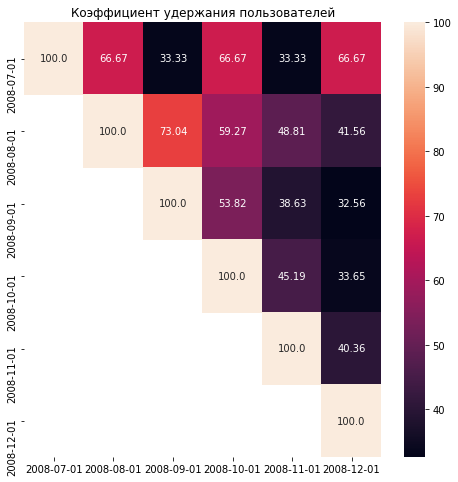

In [19]:
retention = eight.pivot('cohort_dt', 'session_date', 'retention_rate')
retention.index = [str(x)[0:10] for x in retention.index]
retention.columns = [str(x)[0:10] for x in retention.columns]

plt.figure(figsize=(8, 8)) 
sns.heatmap(retention, 
            annot=True, 
            fmt='') 
plt.title('Коэффициент удержания пользователей') 
plt.show()

 В когортах, сформированных в августе и последующие месяцы коэффициент удержания логично  со 100 % в месяц создания постепенно снижается в последующие месяцы, что вполне объяснимо тем, что заинтересованность части пользователей в сайте может постепенно снижаться и по истечении некоторого времени они вовсе перестают его посещать. 
    
Для пользователей, впервые разместивших пост в июле 2008 года, начиная с августа коэффициент удержания "скачет" через месяц от 66 % до 33 %. В абсолютных значениях - это с 3 до 2 пользователей.
    
Как уже пояснялось ранее (к задаче 3) период начала опытной эксплуатации сайта StackOverflow -начало августа 2008 года. Вполне возможно что это первые пользователи из команды разработчиков сайта, тестировавшие  работу сайта на своих данных, которые так и остались в базе.
    
Проверим эту гипотезу, отобрав имена пользователей по уже известному месяцу образования когорты - июль 2008 года.
</div>      

In [20]:
query = '''
SELECT DISTINCT us.display_name,
       DATE_TRUNC('month', ps.creation_date)::date AS cohort_dt
FROM stackoverflow.users AS us
JOIN stackoverflow.posts AS ps ON us.id = ps.user_id
WHERE DATE_TRUNC('month', ps.creation_date)::date  = '2008-07-01'
'''
eight = pd.read_sql_query(query, con=engine)
eight               

,display_name,cohort_dt
0,Eggs McLaren,2008-07-01
1,Jeff Atwood,2008-07-01
2,Kevin Dente,2008-07-01


 Похоже, что все так и есть, в первой когорте Jeff Atwood - один из основателей  StackOverflow.
</div>    

# Задание 9


На сколько процентов менялось количество постов ежемесячно с 1 сентября по 31 декабря 2008 года? Отобразите таблицу со следующими полями:

- номер месяца;
- количество постов за месяц;
- процент, который показывает, насколько изменилось количество постов в текущем месяце по сравнению с предыдущим.

Если постов стало меньше, значение процента должно быть отрицательным, если больше — положительным. Округлите значение процента до двух знаков после запятой.

Напомним, что при делении одного целого числа на другое в PostgreSQL в результате получится целое число, округлённое до ближайшего целого вниз. Чтобы этого избежать, переведите делимое в тип `numeric`.

| creation_month | posts_count | percentage |
| -------------- | ----------- | ---------- |
| 9 | 70731 | Nan |
| 10 | 63102 | -10.33 |
| ... | ... | ... |

In [21]:
query = '''
WITH month_post AS (SELECT EXTRACT(MONTH from creation_date::date) AS creation_month,
                    COUNT(DISTINCT id) AS posts_count   
                    FROM stackoverflow.posts
                    WHERE creation_date::date BETWEEN '2008-09-01' AND '2008-12-31'
                    GROUP BY creation_month)

SELECT *,
       ROUND(((posts_count::numeric / LAG(posts_count) OVER (ORDER BY creation_month)) - 1) * 100, 2) AS percentage
FROM month_post;
'''
nine = pd.read_sql_query(query, con=engine)
nine

,creation_month,posts_count,percentage
0,9.0,70371,NaN
1,10.0,63102,-10.33
2,11.0,46975,-25.56
3,12.0,44592,-5.07


<details>

<summary>Подсказка</summary>
Эту задачу стоит декомпозировать. Сформируйте запрос, который отобразит номер месяца и количество постов. Затем можно использовать оконную функцию, которая вернёт значение за предыдущий месяц, и посчитать процент.
</details>

Постройте круговую диаграмму с количеством постов по месяцам.

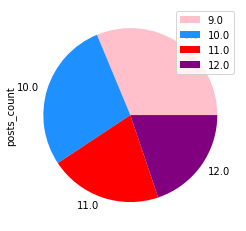

In [22]:
ax = nine.groupby(['creation_month']).sum().plot(kind='pie', y='posts_count', colors = ['pink', 'dodgerblue', 'red', 'purple'])

# Задание 10

Выгрузите данные активности пользователя, который опубликовал больше всего постов за всё время. Выведите данные за октябрь 2008 года в таком виде:

- номер недели;
- дата и время последнего поста, опубликованного на этой неделе.

| week_creation | creation_date |
| ------------- | ------------- |
| 40 | 2008-10-05 09:00:58 |
| 41 | 2008-10-12 21:22:23 |
| ... | ... |

In [23]:
query = '''
WITH l AS
(WITH n AS
(SELECT user_id
FROM stackoverflow.posts
GROUP  BY user_id
ORDER BY COUNT(id)DESC
LIMIT 1)
SELECT creation_date,
       EXTRACT('week'FROM creation_date::date) AS week_creation
       FROM stackoverflow.posts
WHERE  user_id IN (SELECT*
                  FROM n)
AND DATE_TRUNC('month', creation_date)::date = '2008-10-01') 
SELECT  DISTINCT week_creation,
        MAX(creation_date) OVER (PARTITION BY week_creation) AS creation_date
FROM l
ORDER BY  week_creation
'''
ten= pd.read_sql_query(query, con=engine)
ten

,week_creation,creation_date
0,40.0,2008-10-05 09:00:58
1,41.0,2008-10-12 21:22:23
2,42.0,2008-10-19 06:49:30
3,43.0,2008-10-26 21:44:36
4,44.0,2008-10-31 22:16:01
